# Indoor Positioning using WiFi Fingerprinting Algorithm

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

from mpl_toolkits.mplot3d import Axes3D

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

np.random.seed(24680)

## Abstract
The Global Positioning System (GPS) is used to provide positioning capabilities. It requires only a suitable receiver which eanbles its widespread usage. However in most indoor contexts like high buildings multi-level highways and tunnels the GPS technology does not provide an accurate result or cannot be used [[1](#ref_1)].

This could be solved by using Indoor Positioning Systems (IPS). It can be supported by various technologies like geomagnetic and radio signal sensing, inertial data measurements and computer vision. Typical application areas include Ambient Assisted Living (AAL) [[2](#ref_2) , [3](#ref_3) , [4](#ref_4)], Internet of Things (IoT) networks [[5](#ref_5) , [6](#ref_6)], tracking and navigation [[6](#ref_6)].

In many deployment of dedicated positionning infrastructure is often avoded or may be impossible due to costs, security and limits on installable devices. This is especailly valid for public areas, hospitals, universities and cultural heritage sites. In these cases the esistings signals should be used. This is done by the fingerprinting algorithms which use the signals strength to create localization maps. The position is estimated by comparisons with the real time signal measurement. 

The requirements for fingerprinting algorithms implementation are met by the currently available smartphones and wearable devices. They present a convenient and cost effective platform with on-board sensors and adequate computational power. 

This project proposes a fingerprinting positioning algorithm based on WiFi signals strength data.

## Dataset
Geo-Magnetic field and WLAN dataset for indoor localisation from wristband and smartphone Data Set [[7](#ref_data)] is a multisource and multivariate dataset. It can be used for developing and testing novel
approaches to the indoor localization problem. Collecting of data was done simultaneously by two different devices: a smartphone and a smartwatch. Each device collected multivariate data represented by their inertial parameters (acceleration, orientation and gyroscope), geo-magnetic field, and received signal strengths from Wi-Fi access points.

Download link:
[Geo-Magnetic field and WLAN dataset for indoor localisation from wristband and smartphone Data Set](https://archive.ics.uci.edu/ml/datasets/Geo-Magnetic+field+and+WLAN+dataset+for+indoor+localisation+from+wristband+and+smartphone)

## WiFi data
The research on IPS based on WiFi Received Signal Strength Indicator (RSSI) values has been the most popular due to the ease of access of RSSI information from basically any mobile device. This made WiFi fingerprinting one of the most popular methods for indoor positioning.

The produced signal strength map strongly the positioning performance so it should be designed accurately according wireless signal density and positional data.

## WiFi dataset description
Each rows contains PlaceId (ascending order) and 127 column, with RSSI level for each different wireless access points (WAP)s retrieved during the campaign. Not all the WAPs are detected in each scan.
For these WAPs, the articial RSSI value is -100 (dbm).

Each PlaceId represents unique position ot the map defined by (X,Y) coordinates in meters. This is defined in a separate dataset.

## Position dataset description
Data is converted from Pointsmapping.ods to a CSV file. It is three column spreadsheet (ID,X,Y) which points mapping in local coordinates. Each ID represents an unique place on the map. The X-Y coordinates represents the local coordinates. Local coordinates are given considering the X-Y axis origin on the bottom-left corner. By this point, each bullet is 0.6 meters far from another since each tile is 0.6m X 0.6m.

In [3]:
# Prepare pseudo random seed

In [4]:
wifi_dataset_1 = pd.read_csv("./data/measure1_smartphone_wifi.csv")
wifi_dataset_2 = pd.read_csv("./data/measure2_smartphone_wifi.csv")

There are two separate datasets. They will be used for cross testing - one for training, the other for testing and vice versa

In [5]:
wifi_dataset_1.dtypes

0          int64
-100       int64
-100.1     int64
-100.2     int64
-100.3     int64
           ...  
-78.1      int64
-100.92    int64
-100.93    int64
-86.1      int64
-86.2      int64
Length: 128, dtype: object

In [6]:
wifi_dataset_2.dtypes

0          int64
-100       int64
-100.1     int64
-100.2     int64
-100.3     int64
           ...  
-88        int64
-100.92    int64
-100.93    int64
-85.3      int64
-83.3      int64
Length: 128, dtype: object

In [7]:
wifi_dataset_1.shape

(324, 128)

In [8]:
wifi_dataset_2.shape

(324, 128)

In [9]:
wifi_dataset_1.isnull().values.any()

False

In [10]:
wifi_dataset_2.isnull().values.any()

False

The labels of the cells are set according to dataset description.

In [11]:
def set_column_labels(wifi_dataset):
    columns_labels = []
    columns_labels.append("PlaceID")
    
    for i in range(1, wifi_dataset.shape[1]):
        columns_labels.append(str(i))
        
    wifi_dataset.columns = columns_labels
    return wifi_dataset

In [12]:
wifi_dataset_1 = set_column_labels(wifi_dataset_1)
wifi_dataset_2 = set_column_labels(wifi_dataset_2)

## WiFi Fingerprinting of Positions
### Initial Place ID analysis
The possibility of PlaceID determination based on the WAP signal strength will be analyzed. For this purpose the Decision Tree [[8](#ref_8)] will be used. It has straightforward implementation and is easy to calculate.

Important data for each feature importance [[9](#ref_9)] can be found based on information gain. The triangulation requires only three sources to estimate postion. This is much less than the available in the dataset. Therefore it is expected that not all the WAPs are required to provide position.

The arguments will be the signal strengths for each WAP and the labels are the PlaceIDs.

In [13]:
dt_arguments_set_1 = wifi_dataset_1.iloc[:, 1:]
dt_labels_set_1 = wifi_dataset_1.iloc[:, 0]
dt_arguments_set_2 = wifi_dataset_2.iloc[:, 1:]
dt_labels_set_2 = wifi_dataset_2.iloc[:, 0]

In [14]:
# Check for consistency

In [15]:
dt_model_set_1 = DecisionTreeClassifier()
dt_model_set_2 = DecisionTreeClassifier()

dt_model_set_1.fit(dt_arguments_set_1, dt_labels_set_1)
dt_model_set_2.fit(dt_arguments_set_2, dt_labels_set_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
dt_model_set_1.score(dt_arguments_set_1, dt_labels_set_1)

0.9753086419753086

In [17]:
dt_model_set_1.score(dt_arguments_set_1, dt_labels_set_1)

0.9753086419753086

From the train scores it can be concluded that in general the PlaceID can be determined by the WAP signal strength.
However certain PlaceIDs are not classified properly. This will be invesigated by comparing the values for WAP signals on these positions.

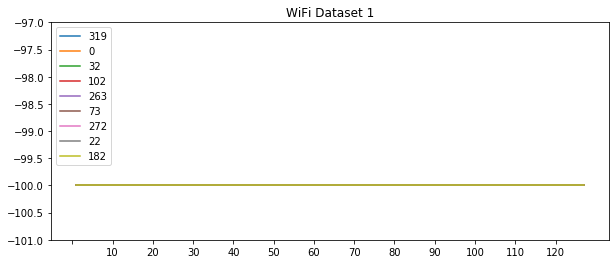

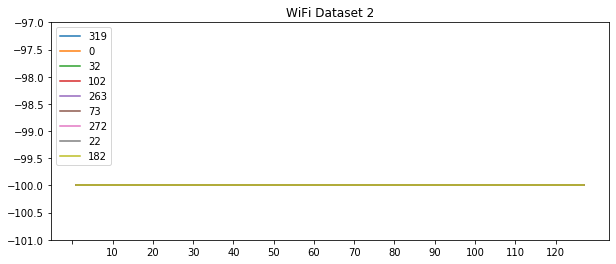

In [18]:
dt_model_map = {
    dt_model_set_1 : "WiFi Dataset 1",
    dt_model_set_2 : "WiFi Dataset 2"
}

# Find list of mispredicted labels
def find_dt_mispredicted(model, arguments, labels):
    mispredicted = set()
    predicted_labels = model.predict(arguments)
    for predicted, expected in zip(predicted_labels, labels):
        if predicted != expected:
            mispredicted.add(predicted)
            mispredicted.add(expected)
    return mispredicted

# Plots WAP values of mispredicted labels
def plot_dt_mispredicted(model, arguments, labels):
    mispredicted = find_dt_mispredicted(model, arguments, labels)
    fig=plt.figure(figsize=(10, 4))
    for label in mispredicted:
        pylab.plot(arguments.iloc[label-1], label=str(label-1))
    pylab.title(dt_model_map[model])
    pylab.legend(loc='upper left')
    pylab.ylim(-101, -97)
    pylab.xticks(np.arange(-1, arguments.shape[1], step=10))
    pylab.show()
        
plot_dt_mispredicted(dt_model_set_1, dt_arguments_set_1, dt_labels_set_1)
plot_dt_mispredicted(dt_model_set_2, dt_arguments_set_2, dt_labels_set_2)

In the graphs of mispredicted labels the value "-100" correspond to no signal. Therefore for the mispredicted labels it can be concluded that in these PlaceID the WiFi was not available. Thus the PlaceID cannot be determined using missing WAP signals.

### Place ID data improvement
The empty signals data, mentioned in the previous paragraph do not contribute to the Place ID determination. They will be removed from the data.

In [19]:
def remove_mispredicted_data(model, arguments, labels):
    mispredicted = find_dt_mispredicted(model, arguments, labels)
    trimmed_arguments = arguments.copy()
    trimmed_labels = labels.copy()
    for label in mispredicted:
        trimmed_arguments.drop(label-1, inplace=True)
        trimmed_labels.drop(label-1, inplace=True)
    return trimmed_arguments, trimmed_labels

In [20]:
dt_arguments_trimmed_set_1, dt_labels_trimmed_set_1 = \
remove_mispredicted_data(dt_model_set_1, dt_arguments_set_1, dt_labels_set_1)
dt_arguments_trimmed_set_2, dt_labels_trimmed_set_2 = \
remove_mispredicted_data(dt_model_set_2, dt_arguments_set_2, dt_labels_set_2)

The Decision Tree modles are retrained with the prepared data.

In [21]:
dt_model_set_1.fit(dt_arguments_trimmed_set_1, dt_labels_trimmed_set_1)
dt_model_set_2.fit(dt_arguments_trimmed_set_2, dt_labels_trimmed_set_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Scores for Decision Trees using prepared data:

In [22]:
dt_model_set_1.score(dt_arguments_trimmed_set_1, dt_labels_trimmed_set_1)

1.0

In [23]:
dt_model_set_2.score(dt_arguments_trimmed_set_2, dt_labels_trimmed_set_2)

1.0

The "1.0" score means that the Place ID can be uniquely determined using the WAP signals. The prepared data will be used for the further investigations.

In [24]:
dt_arguments_set_1, dt_labels_set_1 = dt_arguments_trimmed_set_1, dt_labels_trimmed_set_1
dt_arguments_set_2, dt_labels_set_2 = dt_arguments_trimmed_set_2, dt_labels_trimmed_set_2

Note that the currently trained Decision Trees are not to be used for the datasets cross testing as intention was to determine whether Place ID can uniquely be determined by WAP signal strangths on certain points. Conclusion is that this is possible after removal of points without any signal.

### WAP channel importance
The influence of the WAP channel importance will be analyzed to determine the suffcient quantity of data. For this purpose the WAP channels are sorted by the importance. Then the number of WAP channels for Decision Tree evaluation is decreased started by the least important one.

In [25]:
def get_sorted_important_features(model):
    important_features_dict = {}
    for argument, importance in enumerate(model.feature_importances_):
        important_features_dict[argument] = importance
    
    important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=False)
    
    return important_features_list

In [26]:
'''
Calculates Decision Tree score verus the count of arguments,
decreased by least important features
'''
def calculate_dt_score_vs_args_count(model, arguments, labels):    
    important_features_list = get_sorted_important_features(model)
    
    features_array = []
    score_array = []
    local_train_arguments = arguments
    for feature_index in important_features_list:
        local_model = DecisionTreeClassifier()
        local_model.fit(local_train_arguments, labels)
        features_count = local_train_arguments.shape[1]
        local_score = local_model.score(local_train_arguments, labels)
        score_array.append(local_score)
        features_array.append(features_count)
        local_train_arguments = local_train_arguments.drop(str(feature_index+1), axis=1)
        
    return features_array, score_array

In [27]:
def plot_dt_score_vs_args_count(model, arguments, labels):
    features_array, score_array = calculate_dt_score_vs_args_count(model, arguments, labels)
    plt.figure(figsize=(10, 6))
    
    # Plot partial graph to show meaningful changes
    plt.plot(features_array, score_array)
    plt.xlim(0, 10)
    plt.xlabel('WAPs count (sorted by feature importance)')
    plt.ylabel('Score')
    plt.title(dt_model_map[model])

    # Subplot of whole score vs features_count
    a = plt.axes([0.55, 0.2, .3, .3])
    plt.plot(features_array, score_array)
    plt.title('Complete Data')
    plt.xticks([])
    plt.yticks([])

    plt.show()
    
    return features_array, score_array

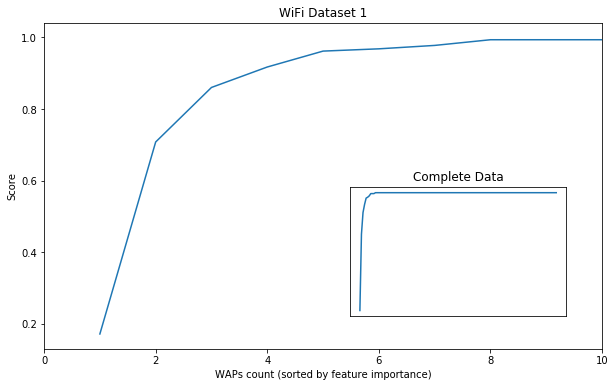

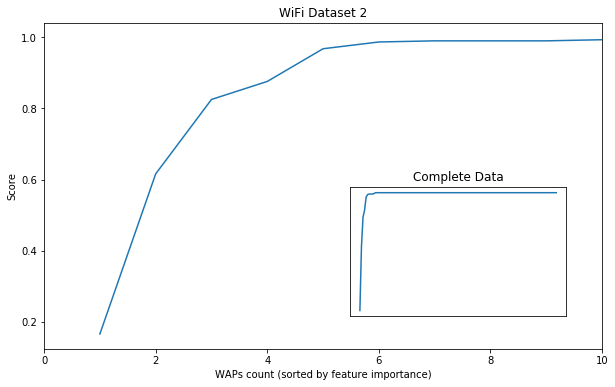

In [28]:
features_array_set_1, score_array_set_1 = \
plot_dt_score_vs_args_count(dt_model_set_1, dt_arguments_set_1, dt_labels_set_1)
features_array_set_2, score_array_set_2 = \
plot_dt_score_vs_args_count(dt_model_set_2, dt_arguments_set_2, dt_labels_set_2)

The results clearly show that the accuarcy of the model is determined by the most important features. The removal of the least important ones does not influence the accuracy of the model. 

Scores for Decision Trees using the three most important features (WAP) data:

In [29]:
# Dataset 1
score_array_set_1[features_array_set_1.index(3)]

0.8603174603174604

In [30]:
# Dataset 2
score_array_set_2[features_array_set_2.index(3)]

0.8253968253968254

For both datasets it can be seen that the ten most important features (as classified by Decision Tree Classifier) are sufficient to provide accuracy as if all the data is used. As previously noted the triangulation requires three independent sources. In this case using the three most important features provides accuracy around 60-80%.

In [31]:
wap_properies_map = {
    np.mean : "Mean Value",
    np.max : "Max Value",
    np.std : "Standard Deviation"
}

# Plot feature importance vs some properties of columns
def plot_properties_vs_feature_importance(current_plot, model, arguments, property_func):
    importances_array = []
    properties_array = []
    for feature_index, importance in enumerate(model.feature_importances_):
        importances_array.append(importance)
        properties_array.append(property_func(arguments.iloc[feature_index]))
        
    current_plot.scatter(importances_array, properties_array)
    current_plot.set_xlabel('Feature Importance')
    current_plot.set_ylabel(wap_properies_map[property_func])
    current_plot.set_title(dt_model_map[model])

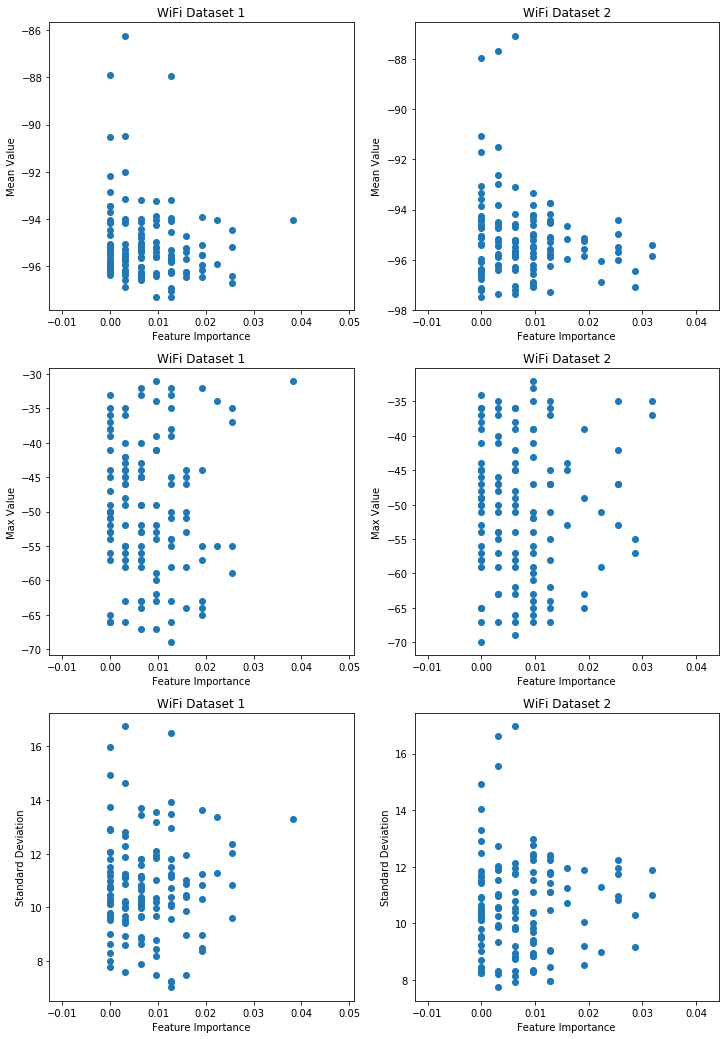

In [32]:
fig, plot_grid = plt.subplots(len(wap_properies_map), len(dt_model_map),  figsize=(12, 18))

plot_properties_vs_feature_importance(plot_grid[0][0], dt_model_set_1, dt_arguments_set_1, np.mean)
plot_properties_vs_feature_importance(plot_grid[0][1], dt_model_set_2, dt_arguments_set_2, np.mean)
plot_properties_vs_feature_importance(plot_grid[1][0], dt_model_set_1, dt_arguments_set_1, np.max)
plot_properties_vs_feature_importance(plot_grid[1][1], dt_model_set_2, dt_arguments_set_2, np.max)
plot_properties_vs_feature_importance(plot_grid[2][0], dt_model_set_1, dt_arguments_set_1, np.std)
plot_properties_vs_feature_importance(plot_grid[2][1], dt_model_set_2, dt_arguments_set_2, np.std)

The properties of WAP signal namely maximal value, mean value and standard deviation from mean show no dependence on feature importance. Thus the sufficient WAPs for mapping cannot be determined apriori by the statistics of the signal.

### Place ID data reduction
In the previous paragraph it was show that accurate determination of Place ID does not require all the WAP data. Decision Tree classifiers provide feature importances which can be used to select data for sufficient accuracy.
However there is no way to distinguish the important features based on their general statistical properties. Considering the datasets in can be seen that the most important features are different:

In [33]:
get_sorted_important_features(dt_model_set_1)[:10]

[8, 9, 14, 15, 24, 26, 30, 32, 37, 57]

In [34]:
get_sorted_important_features(dt_model_set_2)[:10]

[8, 12, 15, 24, 26, 31, 35, 40, 61, 71]

Further analysis requires dimensionality reduction. For this purpose the Principal component analysis (PCA) [[10](#ref_10)] can be applied. It is expected to be useful to process possibly correlated WAP signals, which is based on assumption that the WiFi sources stay on fixed positions. The resulting set of values of linearly uncorrelated variables (principal components) can be used to provide better understanding of the problem. 

In [35]:
pca_set_1 = PCA()
pca_set_2 = PCA()

pca_set_1.fit(dt_arguments_set_1)
pca_transformed_arguments_set_1 = pca_set_1.transform(dt_arguments_set_1)

pca_set_2.fit(dt_arguments_set_2)
pca_transformed_arguments_set_2 = pca_set_1.transform(dt_arguments_set_2)

Graphs of the explained variance

In [36]:
dt_model_map.update( {pca_set_1 : "WiFi Dataset 1"} )
dt_model_map.update( {pca_set_2 : "WiFi Dataset 2"} )

def plot_pca_variance(model):
    plt.figure(figsize=(10, 6))
    
    # Plot partial graph to show meaningful changes
    plt.plot(model.explained_variance_)
    plt.xlim(0, 10)
    plt.xlabel('Principal component')
    plt.ylabel('Explained variance')
    plt.title(dt_model_map[model])
    
    # Subplot of whole score vs features_count
    a = plt.axes([0.55, 0.2, .3, .3])
    plt.plot(model.explained_variance_)
    plt.title('Complete Data')
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

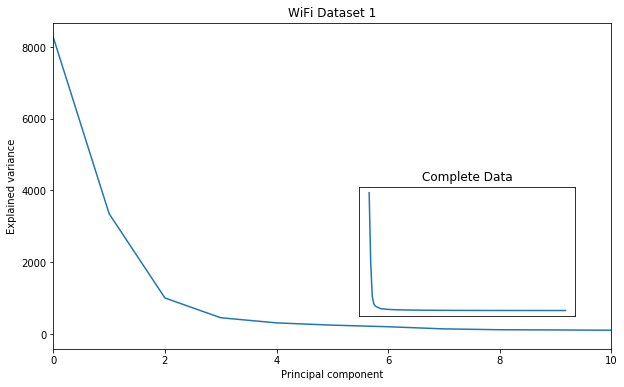

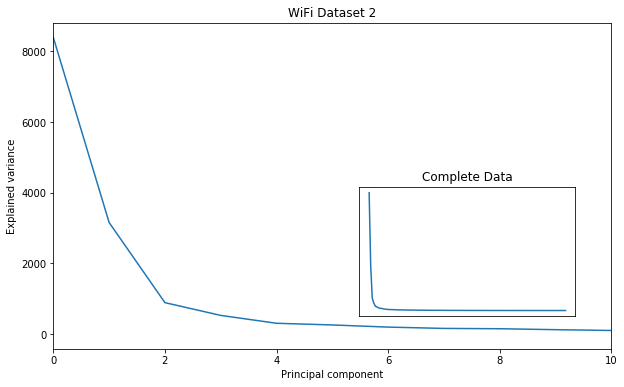

In [37]:
plot_pca_variance(pca_set_1)
plot_pca_variance(pca_set_2)

It can be seen that the first component of the PCA siginficantly outweights the others. So it has to be checked whether only it can be used for analysis.

The PCA transformed data is set to be fitted in Decision Tree models using the first component only.

In [38]:
dt_pca_model_set_1 = DecisionTreeClassifier()
dt_pca_model_set_2 = DecisionTreeClassifier()

dt_pca_model_set_1.fit(pca_transformed_arguments_set_1[:,:1], dt_labels_set_1)
dt_pca_model_set_2.fit(pca_transformed_arguments_set_2[:,:1], dt_labels_set_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
dt_pca_model_set_1.score(pca_transformed_arguments_set_1[:,:1], dt_labels_set_1)

1.0

In [40]:
dt_pca_model_set_2.score(pca_transformed_arguments_set_2[:,:1], dt_labels_set_2)

1.0

It can be concluded that only the first component of the PCA transformed data can be used to determine Place ID from WAP data. 

In [41]:
dt_pca_model_set_2.score(pca_transformed_arguments_set_1[:,:1], dt_labels_set_1)

0.031746031746031744

In [42]:
dt_pca_model_set_1.score(pca_transformed_arguments_set_2[:,:1], dt_labels_set_2)

0.03492063492063492

Note that the PCA transformed data from one dataset is poorly predicted by the model trained by the other dataset. As previously mentioned the currently trained Decision Trees are not to be used for the datasets cross testing. From the data it can be concluded that the Place ID classification is a one-dimensional problem in relation to the WAP data.

### Position data
The main goal of current investigation is to provide algorithm for estimation of the current position based on WiFi signal strength. For this purpose the Place ID has to be replaced with associated coordinates. They are downloaded from separate datafile, which is described previously.

In [43]:
position_data = pd.read_csv("./data/PointsMapping.csv")

In [44]:
position_data.dtypes

ID      int64
X     float64
Y     float64
dtype: object

In [45]:
position_data.isnull().values.any()

False

In [46]:
position_map = position_data.to_dict()
label_map = position_map['ID']

In [47]:
# Print the position of the points
position_coordinates_x = []
position_coordinates_y = []
for key, value in label_map.items():
    position_coordinates_x.append(position_map['X'][key])
    position_coordinates_y.append(position_map['Y'][key])
    

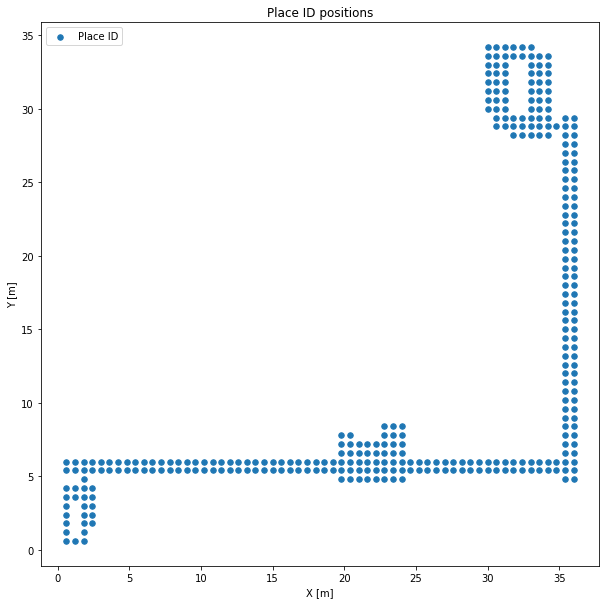

In [48]:
plt.figure(figsize=(10, 10))
plt.title('Place ID positions')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.scatter(position_coordinates_x, position_coordinates_y, label = 'Place ID', s=30)
plt.legend(loc='upper left')
plt.show()

In [49]:
x_map = dict()
y_map = dict()

for key, value in label_map.items():
    x_map[value] = position_map['X'][key]
    y_map[value] = position_map['Y'][key]

In [50]:
labels_coords_set_1 = pd.DataFrame(columns=['X', 'Y'])
labels_coords_set_1['X'] = dt_labels_set_1.apply(lambda x: x_map[x])
labels_coords_set_1['Y'] = dt_labels_set_1.apply(lambda y: y_map[y])

In [51]:
labels_coords_set_2 = pd.DataFrame(columns=['X', 'Y'])
labels_coords_set_2['X'] = dt_labels_set_2.apply(lambda x: x_map[x])
labels_coords_set_2['Y'] = dt_labels_set_2.apply(lambda y: y_map[y])

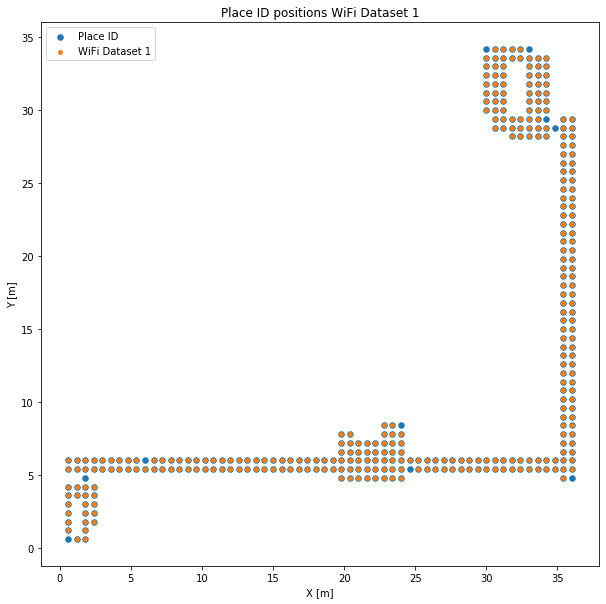

In [52]:
plt.figure(figsize=(10, 10))
plt.title('Place ID positions WiFi Dataset 1')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.scatter(position_coordinates_x, position_coordinates_y, label = 'Place ID', s=30)
plt.scatter(labels_coords_set_1['X'], labels_coords_set_1['Y'], label = 'WiFi Dataset 1', s=15)
plt.legend(loc='upper left')
plt.show()

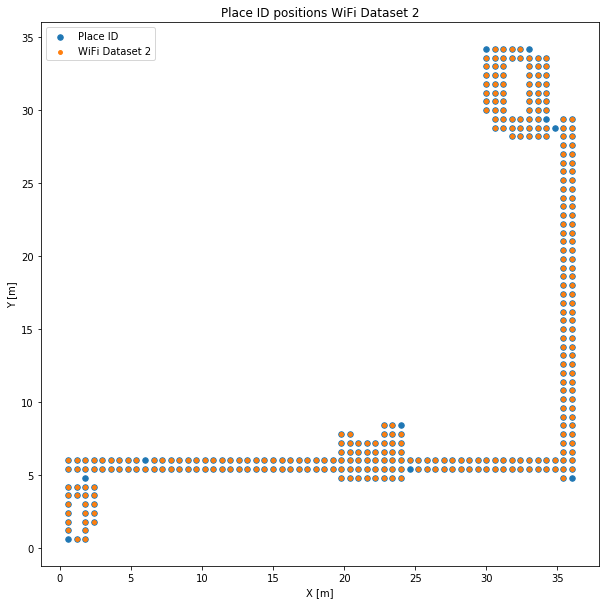

In [53]:
plt.figure(figsize=(10, 10))
plt.title('Place ID positions WiFi Dataset 2')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.scatter(position_coordinates_x, position_coordinates_y, label = 'Place ID', s=30)
plt.scatter(labels_coords_set_2['X'], labels_coords_set_2['Y'], label = 'WiFi Dataset 2', s=15)
plt.legend(loc='upper left')
plt.show()

It has to be noted that the Place ID without any WAP data were removed from the WiFi dataset so their positions in the graphs above are empty.

 ### Fitting Signal data to Position
The relationship between WLAN signals and a Place ID coordinates will be modelled using the LinearRegression approach [[11](#ref_11)] . The dependence of the signal strength versus distance obeys power law [[12](#ref_12)]. However dataset contains values in dBm so the usage of linear model is justified.

In [54]:
regression_model_set1 = LinearRegression()
regression_model_set2 = LinearRegression()

regression_model_set1.fit(dt_arguments_set_1, labels_coords_set_1)
regression_model_set2.fit(dt_arguments_set_2, labels_coords_set_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
predicted_1_on_1 = regression_model_set1.predict(dt_arguments_set_1)
predicted_2_on_1 = regression_model_set1.predict(dt_arguments_set_2)
predicted_1_on_2 = regression_model_set2.predict(dt_arguments_set_1)
predicted_2_on_2 = regression_model_set2.predict(dt_arguments_set_2)

Datasets will be used for corss testing int the following manner: Model trained with first dataset will be tested with the second dataset and vice versa.

Training scores:

In [56]:
# Set 1 train score
train_score_set_1 = r2_score(predicted_1_on_1, labels_coords_set_1)
train_score_set_1

0.9910363411920721

In [57]:
# Set 2 train score
train_score_set_2 = r2_score(predicted_2_on_2, labels_coords_set_2)
train_score_set_2

0.9914720279334633

Test scores:

In [58]:
# Set 1 tested on trained with Set 2
test_score_set_1 = r2_score(predicted_1_on_2, labels_coords_set_1)
test_score_set_1

0.9010801490246492

In [59]:
# Set 2 tested on trained with Set 1
test_score_set_2 = r2_score(predicted_2_on_1, labels_coords_set_2)
test_score_set_2

0.9039095590905319

From the scores results it can be concluded that the initial assumptions for linear dependence between the coordinates and WAP signal points strength are justified. There is tendency to overfit.

The scores above do not provide information for the practial applicability of the method. For this purpose the standard deviation of the predicted coordinates will be calculated.

In [60]:
# Standard deviation of the train data predicted coordinates
train_x_stdev_set_1 = np.std(labels_coords_set_1.X-predicted_1_on_1[:, 0])
train_y_stdev_set_1 = np.std(labels_coords_set_1.Y-predicted_1_on_1[:, 1])
train_x_stdev_set_2 = np.std(labels_coords_set_1.X-predicted_2_on_2[:, 0])
train_y_stdev_set_2 = np.std(labels_coords_set_1.Y-predicted_2_on_2[:, 1])

In [61]:
train_x_stdev_set_1, train_y_stdev_set_1, train_x_stdev_set_2, train_y_stdev_set_2

(1.0530760319924821, 1.0618076499967506, 0.9616851826913789, 1.089547422734973)

The standard deviation of the trained data is about 1m which is a fair result for a testing ground with size around 35 x 35 m.

In [62]:
# Standard deviation of the test data predicted coordinates
test_x_stdev_set_1 = np.std(labels_coords_set_1.X-predicted_1_on_2[:, 0])
test_y_stdev_set_1 = np.std(labels_coords_set_1.Y-predicted_1_on_2[:, 1])
test_x_stdev_set_2 = np.std(labels_coords_set_1.X-predicted_2_on_1[:, 0])
test_y_stdev_set_2 = np.std(labels_coords_set_1.Y-predicted_2_on_1[:, 1])

In [63]:
test_x_stdev_set_1, test_y_stdev_set_1, test_x_stdev_set_2, test_y_stdev_set_2

(4.069593401848531, 3.2296044241964976, 3.4392724595779294, 3.3675860059413827)

The test data deviations are much bigger than the train ones. This confirms the observed previously overfitting.

In [64]:
def plot_predicted_data(predicted_data, expected_data, title):
    fig = plt.figure(figsize=(10, 10))
    for i in range(predicted_data.shape[0]):
        plt.plot([predicted_data[i, 0], expected_data.X.iloc[i]], [predicted_data[i, 1], expected_data.Y.iloc[i]], c='green', linewidth=1)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.scatter(predicted_data[:, 0], predicted_data[:, 1], s=10, c='blue', label = 'Predicted')
    plt.scatter(expected_data.X, expected_data.Y, s=10, c='red', label = 'Expected')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

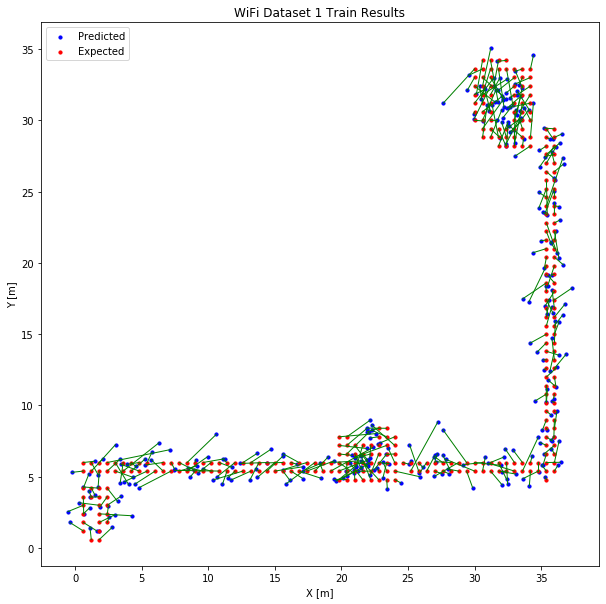

In [65]:
plot_predicted_data(predicted_1_on_1, labels_coords_set_1, 'WiFi Dataset 1 Train Results')

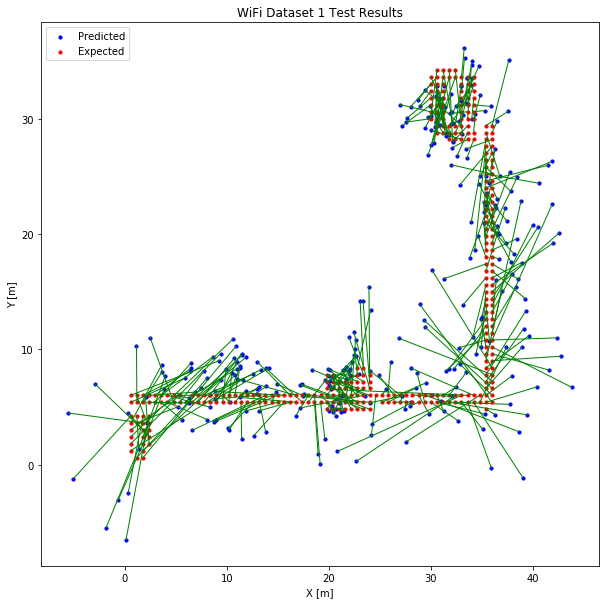

In [66]:
plot_predicted_data(predicted_2_on_1, labels_coords_set_2, 'WiFi Dataset 1 Test Results')

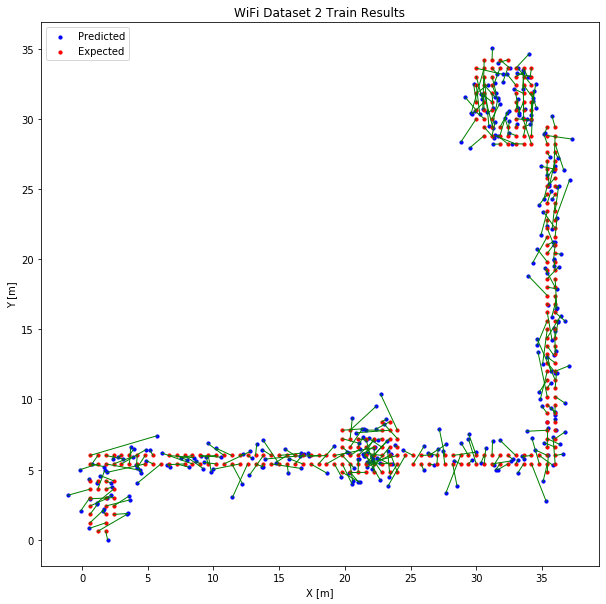

In [67]:
plot_predicted_data(predicted_2_on_2, labels_coords_set_2, 'WiFi Dataset 2 Train Results')

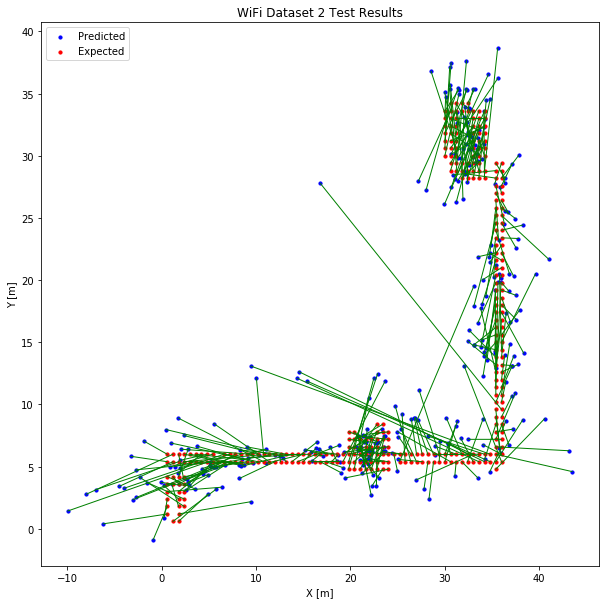

In [68]:
plot_predicted_data(predicted_1_on_2, labels_coords_set_1, 'WiFi Dataset 2 Test Results')

On the graphs the train data overfitting is most evident. The deviation from the expected values during testing is significant. In this setup the method does not seem to be practically usable.

### Feature importance influence on position data
Considering the results from the Place ID analysis it is expected that regularization based on important feature selection could improve accuarcy. The influence of the feature importance on linear regression results will be analyzed.

In [69]:
'''
Calculates Linear Regression score verus the count of arguments,
decreased by least important features
'''
def calculate_lin_regr_score_vs_args_count(model, train_arguments, test_arguments, labels):
    important_features_dict = {}
    for argument, importance in enumerate(model.feature_importances_):
        important_features_dict[argument] = importance
    
    important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=False)
    
    features_array = []
    train_score_array = []
    test_score_array = []
    local_train_arguments = train_arguments
    local_test_arguments = test_arguments
    for feature_index in important_features_list:
        local_model = LinearRegression()
        local_model.fit(local_train_arguments, labels)
        features_count = local_train_arguments.shape[1]
        local_train_score = r2_score(local_model.predict(local_train_arguments), labels)
        train_score_array.append(local_train_score)
        local_test_score = r2_score(local_model.predict(local_test_arguments), labels)
        test_score_array.append(local_test_score)
        features_array.append(features_count)
        local_train_arguments = local_train_arguments.drop(str(feature_index+1), axis=1)
        local_test_arguments = local_test_arguments.drop(str(feature_index+1), axis=1)
        
    return features_array, train_score_array, test_score_array

In [70]:
def plot_lin_regr_score_vs_args_count(model, train_arguments, test_arguments, labels):
    features_array, train_score_array, test_score_array = \
    calculate_lin_regr_score_vs_args_count(model, train_arguments, test_arguments, labels)
    
    # Plot partial graph to show meaningful changes
    plt.figure(figsize=(10, 6))
    plt.plot(features_array, train_score_array, label = 'Train')
    plt.plot(features_array, test_score_array, label = 'Test')
    pylab.legend(loc='lower right')
    plt.xlim(0, 10)
    plt.xlabel('WAPs count (sorted by feature importance)')
    plt.ylabel('Linear Regression R2 Score')
    plt.title(dt_model_map[model])
    plt.show()
    
    # Whole graph score vs features_count
    plt.figure(figsize=(10, 6))
    plt.plot(features_array, train_score_array, label = 'Train')
    plt.plot(features_array, test_score_array, label = 'Test')
    pylab.legend(loc='lower right')
    plt.xlabel('WAPs count (sorted by feature importance)')
    plt.ylabel('Linear Regression R2 Score')
    plt.title(dt_model_map[model] + ' Complete Data')

    plt.show()

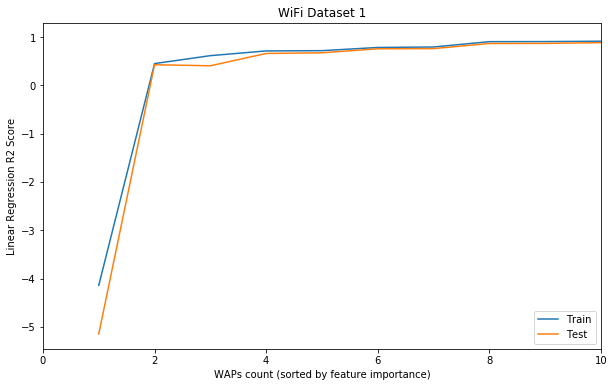

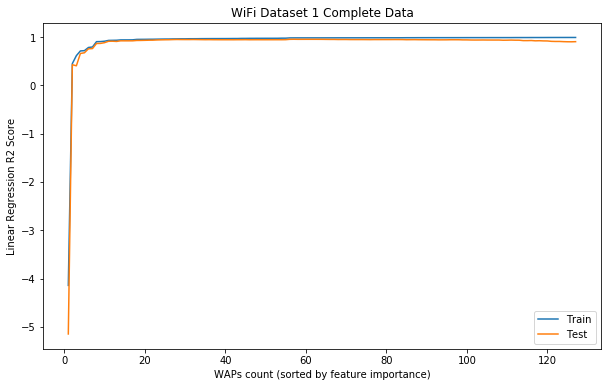

In [71]:
plot_lin_regr_score_vs_args_count(dt_model_set_1, dt_arguments_set_1, dt_arguments_set_2, labels_coords_set_1)

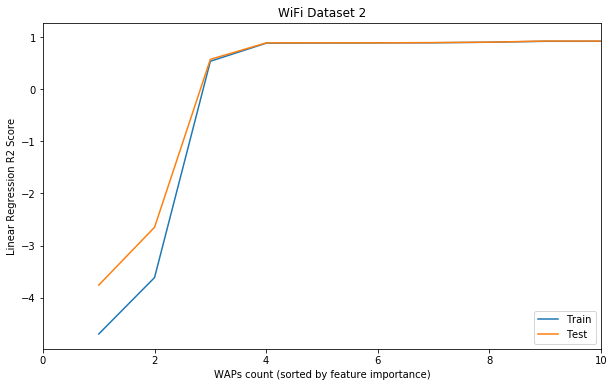

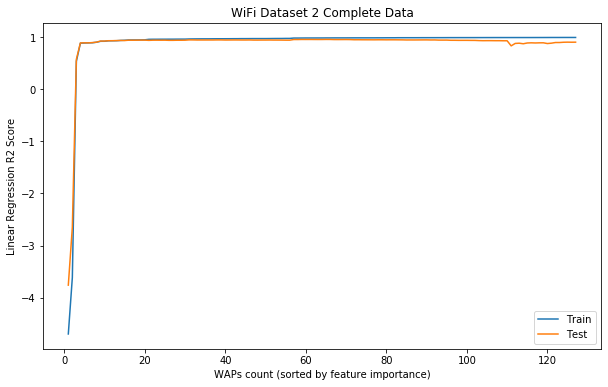

In [72]:
plot_lin_regr_score_vs_args_count(dt_model_set_2, dt_arguments_set_2, dt_arguments_set_1, labels_coords_set_2)

Like in the previous case the removal of the least important features does not decrease the accuracy. However the overfitting is reduced. It can be seen that only the four most important features are required to produce sufficent accuracy. This is close to the number of features, required for triangulation, which is three.
The most importan features will be analyzed.

In [73]:
def cut_off_lin_regr_args(model, cut_off, train_arguments, test_arguments):
    important_features_dict = {}
    for argument, importance in enumerate(model.feature_importances_):
        important_features_dict[argument] = importance
    
    important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=False)
    
    index = len(important_features_list)
    trimmed_train_arguments = train_arguments
    trimmed_test_arguments = test_arguments
    for feature_index in important_features_list:
        trimmed_train_arguments = trimmed_train_arguments.drop(str(feature_index+1), axis=1)
        trimmed_test_arguments = trimmed_test_arguments.drop(str(feature_index+1), axis=1)
        index = index - 1
        if (index == cut_off):
            break
        
    return trimmed_train_arguments, trimmed_test_arguments

In [74]:
cut_train_args_set_1, cut_test_args_set_1 = \
cut_off_lin_regr_args(dt_model_set_2, 10, dt_arguments_set_2, dt_arguments_set_1)
cut_train_args_set_2, cut_test_args_set_2 = \
cut_off_lin_regr_args(dt_model_set_1, 10, dt_arguments_set_1, dt_arguments_set_2)

In [75]:
# Most important features for dataset 1
cut_train_args_set_1.head()

,22,61,97,104,105,106,119,120,124,125
1,-100,-100,-100,-85,-85,-84,-72,-70,-100,-100
2,-100,-100,-100,-100,-100,-84,-71,-70,-100,-100
3,-89,-100,-100,-100,-100,-100,-69,-68,-100,-100
4,-100,-100,-100,-100,-100,-84,-71,-71,-100,-100
5,-89,-100,-100,-100,-100,-100,-67,-68,-100,-100


In [76]:
# Most important features for dataset 2
cut_train_args_set_2.head()

,64,104,105,106,107,108,118,121,122,125
1,-83,-100,-100,-100,-100,-74,-100,-66,-100,-100
2,-83,-100,-100,-100,-100,-80,-100,-69,-100,-100
3,-84,-100,-100,-100,-100,-72,-100,-65,-63,-100
4,-84,-100,-100,-100,-100,-80,-100,-64,-100,-100
5,-86,-100,-100,-84,-85,-73,-100,-65,-64,-100


Like the case of Place ID classification the importance of the WAP signals differs for the two datasets. This makes their cross testing impossible. The application of PCA is expected to provide new set of features to be used for cross testing. The transformed datasets are previously calculated.

### Signal data transformation
Considering the variation importnace graph it is expected that only the three PCA transformed features will be needed to provide sufficient accuracy of the calculations.

In [77]:
pca_lin_regr_arguments_set_1 = pca_transformed_arguments_set_1[:, 0:3]
pca_lin_regr_arguments_set_2 = pca_transformed_arguments_set_2[:, 0:3]

In [78]:
pca_regression_model_set1 = LinearRegression()
pca_regression_model_set2 = LinearRegression()

pca_regression_model_set1.fit(pca_lin_regr_arguments_set_1, labels_coords_set_1)
pca_regression_model_set2.fit(pca_lin_regr_arguments_set_2, labels_coords_set_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
pca_predicted_1_on_1 = pca_regression_model_set1.predict(pca_lin_regr_arguments_set_1)
pca_predicted_2_on_1 = pca_regression_model_set1.predict(pca_lin_regr_arguments_set_2)
pca_predicted_1_on_2 = pca_regression_model_set2.predict(pca_lin_regr_arguments_set_1)
pca_predicted_2_on_2 = pca_regression_model_set2.predict(pca_lin_regr_arguments_set_2)

Train scores for the PCA transformed datasets:

In [80]:
# Set 1 train score
train_score_pca_set_1 = r2_score(pca_predicted_1_on_1, labels_coords_set_1)
train_score_pca_set_1

0.920859104769014

In [81]:
# Set 2 train score
train_score_pca_set_2 = r2_score(pca_predicted_2_on_2, labels_coords_set_2)
train_score_pca_set_2

0.9208031721866096

Test scores for the PCA transformed datasets:

In [82]:
# Set 1 test score
test_score_pca_set_1 = r2_score(pca_predicted_2_on_1, labels_coords_set_2)
test_score_pca_set_1

0.9149946568170138

In [83]:
# Set 2 test score
test_score_pca_set_2 = r2_score(pca_predicted_1_on_2, labels_coords_set_1)
test_score_pca_set_2

0.9226538847857045

Comparison to previous results

In [84]:
train_score_set_1, train_score_set_2, test_score_set_1 , test_score_set_2

(0.9910363411920721,
 0.9914720279334633,
 0.9010801490246492,
 0.9039095590905319)

shows that overfitting of training data was fixed and the accuracy of test data validation was improved.

In [85]:
train_x_stdev_pca_set_1 = np.std(labels_coords_set_1.X-pca_predicted_1_on_1[:, 0])
train_y_stdev_pca_set_1 = np.std(labels_coords_set_1.Y-pca_predicted_1_on_1[:, 1])
train_x_stdev_pca_set_2 = np.std(labels_coords_set_1.X-pca_predicted_2_on_2[:, 0])
train_y_stdev_pca_set_2 = np.std(labels_coords_set_1.Y-pca_predicted_2_on_2[:, 1])

In [86]:
test_x_stdev_pca_set_1 = np.std(labels_coords_set_1.X-pca_predicted_1_on_2[:, 0])
test_y_stdev_pca_set_1 = np.std(labels_coords_set_1.Y-pca_predicted_1_on_2[:, 1])
test_x_stdev_pca_set_2 = np.std(labels_coords_set_1.X-pca_predicted_2_on_1[:, 0])
test_y_stdev_pca_set_2 = np.std(labels_coords_set_1.Y-pca_predicted_2_on_1[:, 1])

Comparison of standard deviation of fitted coordinates

In [87]:
train_x_stdev_pca_set_1, train_y_stdev_pca_set_1 , train_x_stdev_pca_set_2 , train_y_stdev_pca_set_2

(3.3325510394881364, 2.752530363483776, 3.2842285136607856, 2.806755192607965)

In [88]:
test_x_stdev_pca_set_1, test_y_stdev_pca_set_1 , test_x_stdev_pca_set_2 , test_y_stdev_pca_set_2

(3.3946532395465896, 2.773023495864505, 3.3365929385339466, 2.8249935984873957)

to the previous values

In [89]:
train_x_stdev_set_1, train_y_stdev_set_1 , train_x_stdev_set_2 , train_y_stdev_set_2

(1.0530760319924821, 1.0618076499967506, 0.9616851826913789, 1.089547422734973)

In [90]:
test_x_stdev_set_1, test_y_stdev_set_1 , test_x_stdev_set_2 , test_y_stdev_set_2

(4.069593401848531, 3.2296044241964976, 3.4392724595779294, 3.3675860059413827)

shows relative improvement of the testing accuracy. This can be seen on coordinate plots:

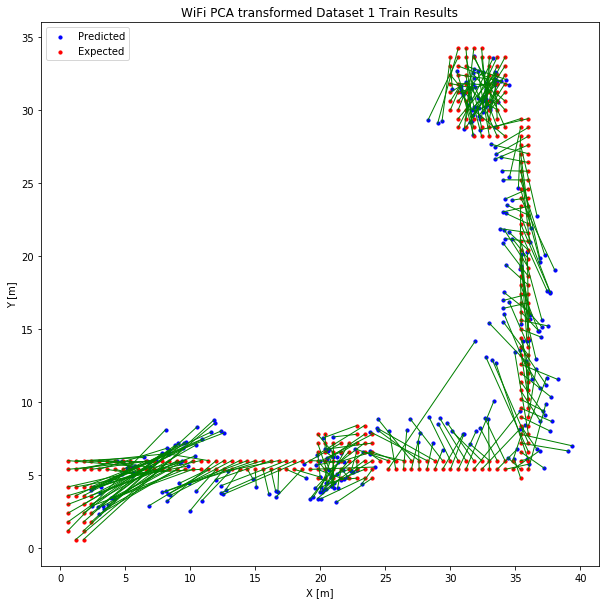

In [91]:
plot_predicted_data(pca_predicted_1_on_1, labels_coords_set_1, 'WiFi PCA transformed Dataset 1 Train Results')

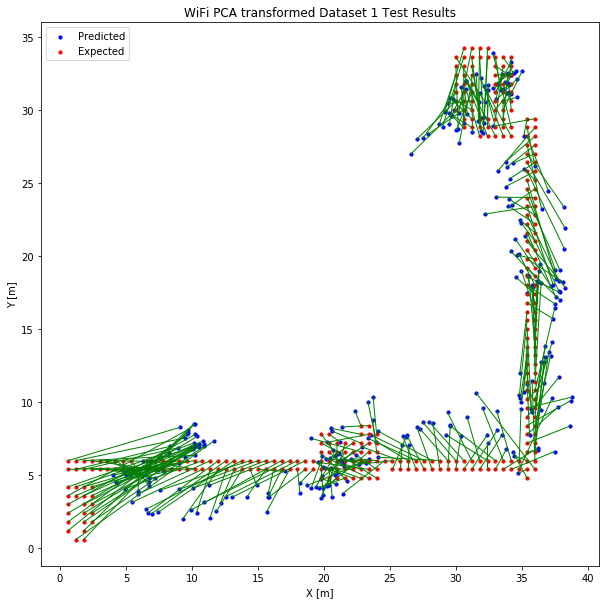

In [92]:
plot_predicted_data(pca_predicted_2_on_1, labels_coords_set_2, 'WiFi PCA transformed Dataset 1 Test Results')

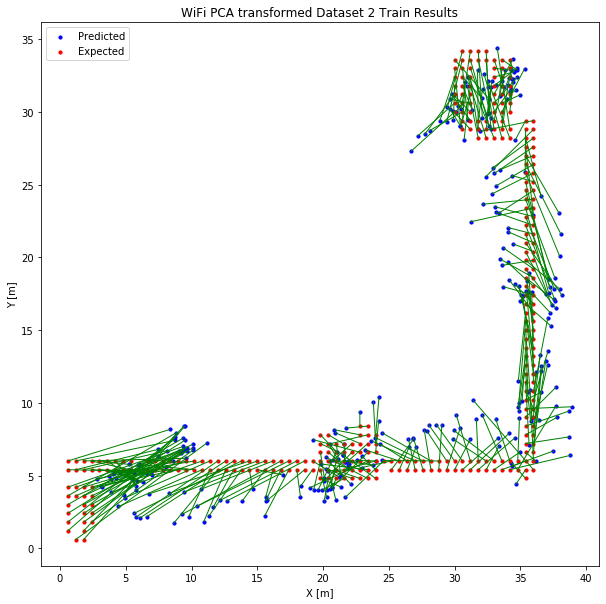

In [93]:
plot_predicted_data(pca_predicted_2_on_2, labels_coords_set_2, 'WiFi PCA transformed Dataset 2 Train Results')

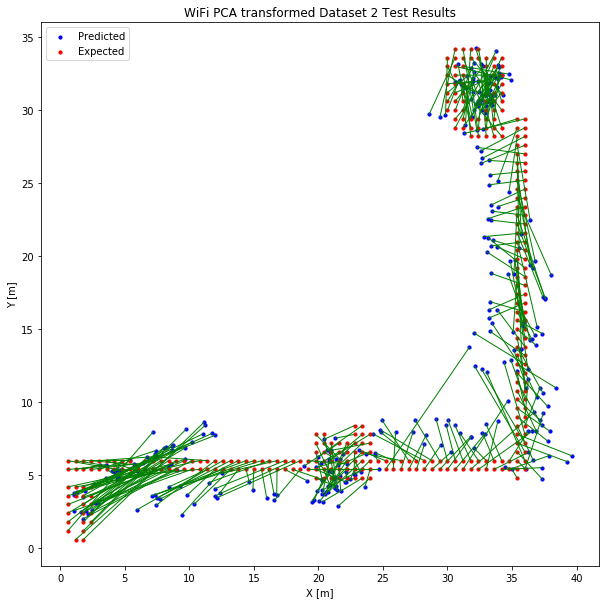

In [94]:
plot_predicted_data(pca_predicted_1_on_2, labels_coords_set_1, 'WiFi PCA transformed Dataset 2 Test Results')

Compared to non PCA transformed data the extreme deviations are reduced. Still the error of position determination is within 3m. It can be concluded that the shown algorithm should be reinforced with other methods to increase the position determination accuracy.

## Conclusions
* Datasets of WAP should be cleared from the empty values (not present WiFi) before further processing.
* The WiFi fingerprinting requires several WAPs only and data reduction could be applied.
* The importance of the WAPs could be determined by the Decision Tree classification.
* The important WAP for a given location do change between different set of measurements so they cannot be used for algorithm training.
* The PCA transformation should be performed on WAP signal data to provide dataset reduction and comparable features.
* The first three PCA resulting features provide accuracy close to maximum.
* Position could be determined from PCA transformed WAP signals using Linear Regression with accuracy about 3m.
* Accuracy can be improved by changing the model or by reinforcement with other methods like geomagnetic fingerprinting.

## References


<a id='ref_1'></a>
1. Li, Binghao, et al. "How feasible is the use of magnetic field alone for indoor positioning?." Indoor Positioning and Indoor Navigation (IPIN), 2012 International Conference on. IEEE, 2012.

<a id='ref_2'></a>
2. P. Barsocchi, S. Chessa, F. Furfari, and F. Potortı, “Evaluating aal solu-
tions through competitive benchmarking: the localization competition,”
IEEE Pervasive Computing Magazine, vol. 12, no. 4, 2013.

<a id='ref_3'></a>
3. F. Potortı̀ and F. Palumbo, “Ceo: A context event only indoor local-
ization technique for aal,” Journal of Ambient Intelligence and Smart
Environments, vol. 7, no. 6, 2015.

<a id='ref_4'></a>
4. P. Barsocchi, A. Cesta, G. Cortellessa, and F. Palumbo, “Monitoring user
position in the giraffplus aal environment,” in Instrumentation and Mea-
surement Technology Conference (I2MTC), 2015 IEEE International.
IEEE, 2015.

<a id='ref_5'></a>
5. A. Cesta, L. Coraci, G. Cortellessa, R. De Benedictis, F. Furfari,
A. Orlandini, F. Palumbo, and A. Štimec, “From sensor data to user
services in giraffplus,” in Ambient Assisted Living. Springer, 2014.

<a id='ref_6'></a>
6. F. Potorti, P. Barsocchi, M. Girolami, J. Torres-Sospedra, and R. Mon-
toliu, “Evaluating indoor localization solutions in large environments
through competitive benchmarking: The evaal-etri competition,” in In-
door Positioning and Indoor Navigation (IPIN), 2015 International
Conference on. IEEE, 2015.

<a id='ref_data'></a>
7. Barsocchi, P., Crivello, A., La Rosa, D., & Palumbo, F. "A multisource and multivariate dataset for indoor localization methods based on WLAN and geo-magnetic field fingerprinting" In Indoor Positioning and Indoor Navigation (IPIN), 2016 International Conference on (pp. 1-8). IEEE.

<a id='ref_8'></a>
8. scikit learn Documentation "1.10. Decision Trees" https://scikit-learn.org/stable/modules/tree.html 17 November 2019

<a id='ref_9'></a>
9. scikit learn Documentation "sklearn.tree.DecisionTreeClassifier"
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_
17 November 2019

<a id='ref_10'></a>
10. scikit learn Documentation "sklearn.decomposition.PCA" https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 17 November 2019

<a id='ref_11'></a>
11. scikit learn Documentation "sklearn.linear_model.LinearRegression" https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html 17 November 2019

<a id='ref_12'></a>
12. Koo, Jahyoung, and Hojung Cha. "Localizing WiFi access points using
signal strength." IEEE Communications letters 15.2, 2011